# **Simulating a LCDM (Lambda Cold Dark-Matter) Universe.**

### **What is LCDM?**
The prevailing cosmological framework that attempts to describe the structure and evolution of our universe.

Specifically, it describes how small density fluctuations in the early universe grew into large-scale structures we see today.

Lets breakdown the term LCDM:
  - **Lambda $Λ$**: dark energy, the force causing the accelerated expansion of the universe. Tied to the *cosmological constant*
    - represents 68.5% of the universe's mass-energy density.
  - **Cold Dark-Matter (CDM):** a form of matter helps form the general structure of the universe. It:
    - does not interact with light (electromagnetic waves) directly.
    - rather, it interacts through gravity.
    - non-baryonic, meaning its not the same as ordinary matter.
    - moves at non-relativisitc speeds, meaning that its slower than light.
    - represents 26.5% of the universe mass-energy density.
  - **Ordinary Matter:** Also known as baryonic matter, its the visible matter that we can observe, like the stars and planets.

This framework predicts a network of dark-matter forming a 'cosmic web', with large notes connected by filaments, which influences the distribution of visible matter.

It assumes the universe constitutes a **flat (euclidian) geometry**

### **Parameter Setup**

Lets setup our parameters for usage.

Will import the desired packages, in particular:
  - **from mpl_toolkits.mplot3d import Axes3D:** Used in tandem with matplotlib for creating 3D visualization. Useful for inspecting particle distributions and cosmic structures visually.
  - **from astropy.cosmology import Planck18:** Loads cosmological parameters from the *Planck 2018* CMB observations, providing standard values (e.g., dark matter density, expansion rate) and convenient methods for cosmological computations.
  - **from scipy.interpolate import RegularGridInterpolator:** Used for interpolation on grids with arbitrary dimensions/spacing.

***Grid parameters:***
  - **N:** The grid size (N x N x N) which defines the simulation resolution. Since we are using *Fast Fourier Transforms (FFTs)* for our simuulation, its good to keep it as a power of 2.
  - **L:** The physical length of one side of the simulated cosmic volume. The larger the length, the bigger the scale of the volume. while smaller lengths provides better resolution of smaller structures. Measured in *Mpc/h.*
  - **k0:** The smallest nonzero wavenumber representable in the box, determined by *2pi/L*. This sets the largest-scale structure that the simulation can model. Essential for accurately generating initial cosmological perturbations. Measured in *h/Mpc.*

***Cosmological Parameters:***
  - **z_start:** The starting redshift at which the simulation's inital conditions are set. Optimal choice balances the two constraints:
    - too early (z ≳ 3000): perturbations are negligible; sim yields little useful structure formation data.
    - too late (z ≲ 10): universe enters non-linear regime, making approximations (e.g., zel’dovich approximation) invalid.
    - thus, around z ≈ 100 (universe age ~160 million years, scale factor a ≈ 0.01) is commonly chosen to start simulations—just late enough that perturbations are non-negligible but early enough to still be linear.
  - **a:** A scale factor, describing the expansion of the universe relative to today (a=1 today). Relates directly to redshift via *a = 1/(1+z)*, and is fundamental for converting between physical and comoving coordinates.
    - a < 1: universe in the past (denser, hotter).
    - a = 1: present day.
    - a > 1: future (less dense, cooler).
  - **ns:** The spectral index it describes how initial density fluctuations vary across different length scales. Based on recent CMB observations, its value is ~0.96, meaning a nearly scale-invariant spectrum (equal fluctuations at all scales), predicted by inflationary models.
    - since its slightly < 1, there is a slighly *red-tilted* spectrum, meaning larger-scale models (smaller k) have slighlt higher amplitude compared to smaller-scale modes, influencing structure formation at different cosmic scales.
  - **D:** The linear growth factor, this quantifies the amplitude growth of initial density fluctuations. Mathematically, it scales the initial fluctiations, evolving them linearly forward in time until nonlinearites take hold, and is a function of redshift *z*. In the matter-dominated era (z >> 1)
    - In the pure matter-dominated era, its roughly *1/(1+z)*, which is *a*. This changes once dark energy kicks in during the later stages of the universe.
  - **H0:** The Hubble Constant, it represents the current expansion rate of the universe, defined at the present (z = 0). It relates the recession velocity of galaxies directly to their proper distance (farther objects move away faster), and is perhaps the most important constant used for calibrating cosmological simulations. Derived from the Hubble Parameter, so this value changes with time. Measured in *km/s/Mpc.*
  - **H:** The Hubble Parameter, describing the instantaneous expansion rate at any given cosmic epoch. Its the time-dependent analog of *H0*, defined at artitray redshift. Measured in *km/s/Mpc.*
    - In early epoch where z is large, *H* is significantly larger due to the denser matter-energy content in the universe.
  - **A:** The power spectrum amplitude, this is the normalization factor for the inital power spectrum. This determines how strongly density fluctuations appear initially, directly impacting the amplitude of cosmic structure formation later.
    - Tuned empirically or via observed constraints to match current cosmic structures.
  - **f:** The growth rate of density perturbations. Essentially measures how quickly fluctuations are growing relative to the universe's expansion. In a high redshift, its appriximately 1.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from astropy.cosmology import Planck18
from astropy.cosmology import FlatLambdaCDM
from scipy.interpolate import RegularGridInterpolator

# Grid params.
N = 128
L = 1000
k0 = 2 * np.pi / L

# Cosmological params.
z_start = 99
a = 1 / (1 + z_start)
ns = 0.96
D = 1 / (1 + z_start)
H0 = Planck18.H0.value
H = Planck18.H(z_start).value
A = 2.1e-9
f = Planck18.Om(z_start)**0.55
h = Planck18.h
omega_m = Planck18.Om0
sigma8 = 0.8


print(f"The Hubble parameter at redshift z={z_start}: {H} km/s/Mpc")
print(f"The current Hubble constant (at z=0): {H0} km/s/Mpc")
print(f"The hubble constant scaling factor (just the hubble constant without dimensions): {h}")
print(f"The fundamental wavenumber k0 (largest scale mode), given box size L: {k0} h/Mpc")
print(f"The linear growth factor at initial redshift (z={z_start}): {D}")
print(f"The growth rate of density perturbations at z={z_start}: {f}")
print(f"The present-day matter density parameter Ω_m (at z=0): {omega_m}")
print(f"The present-day sigma_8 parameter (at z=0): {sigma8}")

The Hubble parameter at redshift z=99: 38244.35636301532 km/s/Mpc
The current Hubble constant (at z=0): 67.66 km/s/Mpc
The hubble constant scaling factor (just the hubble constant without dimensions): 0.6766
The fundamental wavenumber k0 (largest scale mode), given box size L: 0.006283185307179587 h/Mpc
The linear growth factor at initial redshift (z=99): 0.01
The growth rate of density perturbations at z=99: 0.9829420422520284
The present-day matter density parameter Ω_m (at z=0): 0.30966
The present-day sigma_8 parameter (at z=0): 0.8


### **Gaussian Random Field (GRF)**

Firstly, we want to generate a 3D **Gaussian Random Field (GRF)** which will represent tiny fluctuations in densities from the early universe!

So what is a *GRF?*:
  - its essentially a collection of random variables indexed from some continuous space (like points in space and time), that follows a gaussian (normal) distribution.
  - Its based on the following:
    - **mean function:** the average value you would expect at any given point in space. Usually set at 0, since we are modeling fluctuations about the mean density of the universe.
    - **covariance function:** how the random values at different points are related to each other. So for instance, points closer to each other may have similar values.
  - Over time, this field will evolve into cosmic structures.

We will build a GRF based on the power spectrum, linear growth factor, and FFT for efficiency. Thus, here are our basic steps:

  1. **Define the Power Spectrum:**
    - this describes the distribution of matter and energy fluctiations across different scales in the universe. Mathematically, it describes the density contrast of the universe (the difference between the local density and the mean density), as a function of scale.
    - On large scales, gravity competes with the cosmic expansion, and the structures grow linearly. On smaller scales, non-linear gravitational collapse dominates.
    - P(k) ~ k^ns * A

In [ ]:
def power_spectrum(k, A, ns, transfer):
  return np.where(k > 0, A * (k ** ns) * (transfer(k)), 0)  # Vectorized to handle arrays.

2. **Define the Transform Function:**
  - This function essentially shapes the power spectrum by encoding the evolution of the initial density perturbations. It "transfers" the initial density fluctuations into the distributions seen today.
  - Defined as T(k), it modifies P(k). Without it, P(k) is simply just a power law. This is fine for large sclaes, but not smaller scales!
    - for small scales, we can use T(k) to adjust P(k), by suppressing or enchancing power based on cosmological effects.

  - Obtaining T(k) -  we can use three methods to get our transfer function:
    - Analytical approximations: Eisenstein & Hu (1998) fitting function. Fast to compute, but accurate to (2-5%). The other methods are more precise.
    - Precomputed tables: Boltzmann codes like CAMB or CLASS for T(k) computation. This is more precise with sub-percent level accuracy (up to ~0.1%), but slower than approximations.
    - Libraries: python pkgs like colossus or hmf.

  - We will use the Eisentein & Hu fitting function below, for simplicity:

In [ ]:
# Transfer function T(k).
def eisenstein_hu(k, omega_m, h):
  q = k / (omega_m * h**2)
  return (np.log(1 + 2.34 * q) / (2.34 * q)) * (1 + 3.89 * q + (16.1 * q)**2 + (5.46 * q)**3 + (6.71 * q)**4)**(-0.25)

2. **Fourier Space Setup:**
  - Represents the domain in which functions are expressed in terms of their frequency components rather than their spatial temporal coordinates.
  - Since the GRF is defined over a continous space, its easier to generate a fourier space (wavenumber domain), and then transform back into real space.
    - Each point in the fourier space corresponds to a wave number with certain wavelength and amplitude. The lowest frequency (largest wavelength) is determined by the simulation's box size *L*.
  - Computations like differentiation becomes algebraic in Fourier Space, simplifying the process, and for systems with periodic boundary conditions, wavenumber grids naturally represent the allowed modes of oscillation.

In [ ]:
# Setting up the 3D coordinate grids in Fourier space.
k_coords = np.fft.fftfreq(N) * N * k0
kx, ky, kz = np.meshgrid(k_coords, k_coords, k_coords, indexing='ij')
k = np.sqrt(kx**2 + ky**2 + kz**2) # Magnitude of k vector.

3. **Generating the GRF in Fourier Space:**
  - For each wavenumber k, we can assign a random complex number (amplitude) drawn from the gaussian.
    - mean = 0 of course.
    - variance is set by the power spectrum P(k).
    - This makes the field have the right amount of variance at each scale.
  - Complex Gaussian Noise:
    - when we generate our field with real and imaginary parts, each drawn from the gaussian (N(0, 1)), we will scale it by sqrt(P(k)/2). We do this since the variance of the complex field is the sum of the variances of the real and imaginary parts:

    - 2 * sqrt[P(k)/2]^2 = P(k)

  - Hermitian Symmetry:
    - So that the inverse FFT yields a real-valued field in real space.

  - FFT is key. Its fast, turing a N^3 grid computation into something like N^3logN for large sims.

In [ ]:
np.random.seed(43)

transfer = lambda k: eisenstein_hu(k, omega_m, h)
variance = power_spectrum(k, A, ns, transfer)

# Complex Gaussian noise: real and imaginary parts ~ N(0, sqrt(P(k)/2))
field_k = (np.random.normal(0, 1, (N, N, N)) +
           1j * np.random.normal(0, 1, (N, N, N))) * np.sqrt(variance / 2)
# Ensure Hermitian symmetry for real output (field_k[-k] = conj(field_k[k]))
field_k[tuple(-i % N for i in np.indices((N, N, N)))] = np.conj(field_k)
field_k[0, 0, 0] = 0

<ipython-input-3-019d825ebeac>:4: RuntimeWarning: invalid value encountered in divide
  return (np.log(1 + 2.34 * q) / (2.34 * q)) * (1 + 3.89 * q + (16.1 * q)**2 + (5.46 * q)**3 + (6.71 * q)**4)**(-0.25)


4. **Applying the linear growth factor D:**
  - Initial perturbations grow linearly as gravity pulls matter together, balanced against the expansion.
  - The linear growth factor D scales these fluctuations linearly with time, as it was linear in the early universe. Thus:
    - Multiplying the field by D in order to evolve the field from the initial conditions to some later time.

In [ ]:
field_k *= D

5. **Transforming the Fourier Space into Real Space using inverse FFT:**
  - Once the field is built in fourier space, use inverse FFT to transform it back into real space.
  - The result is a 3D grid of density values: a realization of the GRF field!
  - Make sure only taking the real parts of the field.

In [ ]:
field_real= np.fft.ifftn(field_k)
density_field = np.real(field_real)

6. **Normalize to overdensity:**
  - Finally, the density field is expressed as overdensity δ, the fractional difference between the local density and the mean density. This, its essentially a map of density fluctuations.
    - positive overdensity mark regions destined to form large cosmic structures like galaxies and such.
    - negative overdensities mark regions destined to be underdense voids so to speak.
  - This is crucial for the formation of large-scale structures of the universe!
  - Mathematically, its defined as:
    
    δ(x) = (ρ(x)− ρ') / ρ'


In [ ]:
# mean=0, variance can be adjusted.
#density_field -= np.mean(density_field)

Now that we effectively have our density field, we can visualize.

In [ ]:
current_std = np.std(density_field)
print(f"Current std of density field: {current_std}")

target_std = sigma8 * D
density_field *= target_std / current_std
print(f"New std of density field: {np.std(density_field)}")

Current std of density field: 1.8825155703642606e-11
New std of density field: 0.007999999999999998


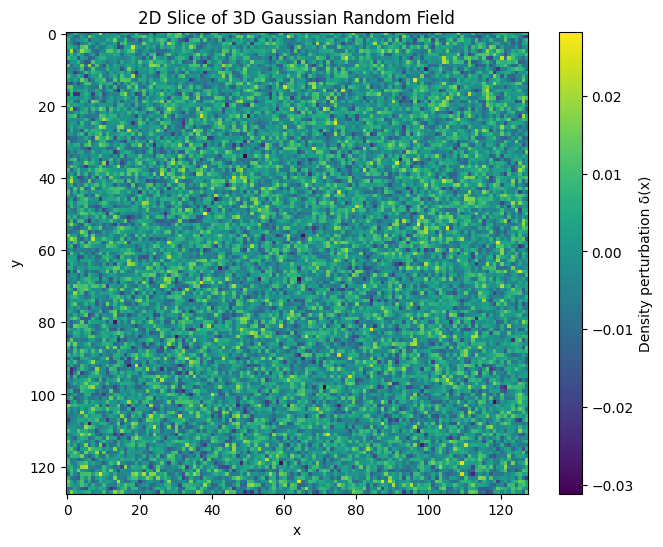

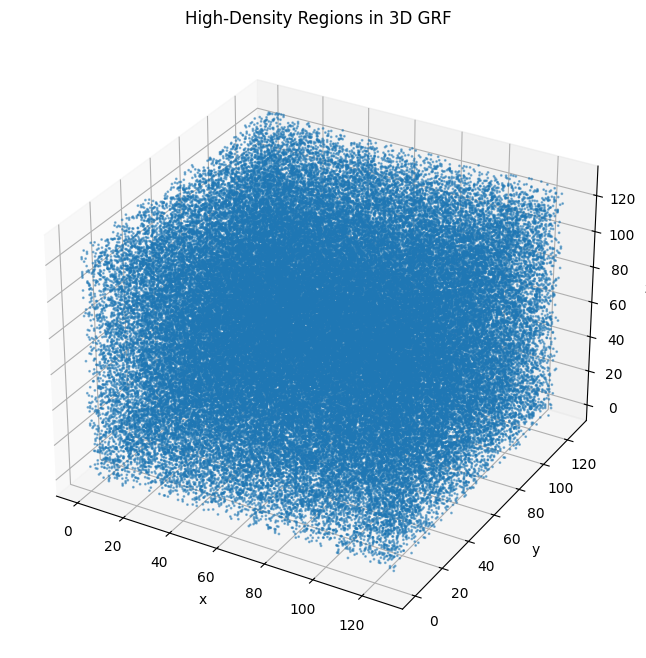

Mean density: -1.0587911840678754e-22
Standard deviation: 0.007999999999999998
Min density: -4.206e-02, Max density: 4.052e-02


In [ ]:
# Visualization of the density field, a 2D slice.
plt.figure(figsize=(8, 6))
plt.imshow(density_field[N//2, :, :], cmap='viridis')
plt.colorbar(label='Density perturbation δ(x)')
plt.title('2D Slice of 3D Gaussian Random Field')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Also, a 3D scatter plot of the high density regions.
threshold = np.percentile(density_field, 95)  # Top 5% density
high_density = np.where(density_field > threshold)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(high_density[0], high_density[1], high_density[2], s=1, alpha=0.5)
ax.set_title('High-Density Regions in 3D GRF')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

# Finally, lets print some stats.
print(f"Mean density: {np.mean(density_field)}")
print(f"Standard deviation: {np.std(density_field)}")
print(f"Min density: {np.min(density_field):.3e}, Max density: {np.max(density_field):.3e}")

The stats makes sense:
  - **Mean density:** very close to 0, meaning that we correctly shifted the density field's mean to 0, thus correct normalization.
  - **std dev:** close to the target std, which is 0.008. Good, since it alleviates the extremely small variance/displacement values.
  - **Min/Max densities:** looks good as well, since it shows our initial over and underdensities. Small initial density perturbations.

### **Zel'dovich Approximation**
The Zel'dovich Approximation is a 1st order perturbative method that approximates how the small initial density fluctuations (GRF) evolved into today's cosmic structure. It helps bridge the gap between the early linear regime (small perturbations) and the later non-linear regime (matter collapse and structure formation).

Instead of solving complex, fully non-linear equations of motion, the zel'dovich approx. linearly displaces particles from their original grid positions using gravitational potentials derived from the initial density field.

***Conceptually:***
  - particles are initially placed evenly on a uniform grid *lagrangian coordinates (q)*.
  - as the space expands, gravity amplifies the initial fluctuations.
  - overdense regions grow denser, pulling matter in, while underdense regions becoming voids.
  - the approximation similates this by moving particles according to the graviational poterntial, calculated directly from the initial density fluctuations.

***Graviational potential Φ:***
  - a scalar field that measures how much gravtational "energy" or "potential" exists at each point in space.
  - related to the overdensity via the *poisson's equation:*

    ∇^2ϕ(x)=δ(x)
  - basically, very dense regions (positive overdensity) creates deep, negative graviational potentials, meaning that matter are pulled into these regions, while less dense regions (negative overdensity) creates more shallow potentials, meaning matter are less likely to get pulled into them.

***Displacement Field Ψ:***
  - a vector field indicating how far and in what direction particles shift from their original uniform grid positions due to the graviational potential.
  - related to the gravitational potential via:

  Ψ(x)=−∇ϕ(x)

  - this shows that the displacement is essentially the negative gradient of the potential.
  - the displacement vector determines how each particle moves away from the initial grid positions due to the potential. When we apply this gradient to the inital positions, the result will be *eulerian coordinates (x)*.

  Lets break it down! Here are the steps:

1. **Computing the Displacement in One Specific Direction (x, y, z)**
  - We can create a function that  will facilitate the computation of the displacement field in one direction (x, y, z) from the gravitational potential in Fourier Space, as well as the wavenumber component in that specific direction.

    1. Take our grativational potential, as well as the specific direction as args for our function.
    2. Calculate the displacement:
      - In Fourier Space, we can just multiply the potential with -ik, since differentiation in real space corresponds to multiplication of ik in in Fourier.
      - Displacement Ψ = -∇φ, ===> Ψ_i(k) = -i  * k_i φ(k)
    3. From there, we just transform it back to Real Space.

In [ ]:
def zeldovich_one_direction(potential_k, k_dir):
  displacement_k = -1j * k_dir * potential_k
  displacement_real = np.real(np.fft.ifftn(displacement_k))
  return displacement_real

2. **Full 3D Zel'Dovich Approximation:**:
  - Computation of the 3D displacement field from the densitiy field. Lets take the denisty field computed above and return the 3D displacement field via the following regimen:
    
    1. FFT the density field δ(x) into δ(k).
    2. Set up the wavenumbers k coords like before.
    3. Computation of the gravitational potential φ(k) from δ(k): ∇²φ = δ ===> φ(k) = -δ(k)/k²
    4. Compute the displacements in each direction. For this we will call the dedicated function `zeldovich_one_direction(potential_k, k_dir)` that takes the graviational potential and each direction (x, y, z) as parameters and then calculate each, returning an array that holds each displacement at that direction.
    5. Finally, just multiply the displacements by the linear growth factor D. this scales from the initial redshift to the desired sim epoch.

In [ ]:
def zeldovich(density_field):
  density_k = np.fft.fftn(density_field)

  # Setting up the 3D coordinate grids in Fourier space.
  k_coords = np.fft.fftfreq(N) * N * k0
  kx, ky, kz = np.meshgrid(k_coords, k_coords, k_coords, indexing='ij')
  k2 = kx**2 + ky**2 + kz**2
  k2[0,0,0] = 1.0           # Avoiding division by zero at k=0

  # Gravitional potential.
  potential_k = -density_k / k2
  potential_k[0,0,0] = 0    # mean displacement = 0

  displacements = np.zeros((3, N, N, N))
  displacements[0] = zeldovich_one_direction(potential_k, kx)
  displacements[1] = zeldovich_one_direction(potential_k, ky)
  displacements[2] = zeldovich_one_direction(potential_k, kz)

  return displacements

3. **Initializing Particle positions and application of the Displacement:**
  - Given our computed displacements at each direction, we can initialize some particle positions on a grid and then displace them.

    1. Initialize a uniform grid of initial positions (Lagrangian Coordinates q) via stacking three N^3 arrays, and reshaping it so that the shape will be of (N_part^3, 3).
    2. Make sure we interpolate the displacements to the particle grid IFF N_part != N.
    3. From there, simply add the positions to the displacements and return the new positions.
      - *Eulerian Coordinates x*: x = q + Ψ(q), being a (N_part^3, 3) array of eulerian particle positions.

In [ ]:
def zeldovich_positions(N_part=N):
  displacements = zeldovich(density_field)
  grid_1d = np.linspace(0, L, N_part, endpoint=False)
  qx, qy, qz = np.meshgrid(grid_1d, grid_1d, grid_1d, indexing='ij')
  positions = np.stack([qx, qy, qz], axis=-1).reshape(-1, 3)

  # Interpolating the displacements to the particle grid if N_part != N.
  if N_part != N:
    grid_points = np.linspace(0, L, N, endpoint=False)
    interp = RegularGridInterpolator((grid_points, grid_points, grid_points),
                                    displacements.transpose(1, 2, 3, 0))
    disp_at_q = interp(positions)
  else:
    disp_at_q = displacements.transpose(1, 2, 3, 0).reshape(-1, 3)

  positions += disp_at_q
  return positions

4. Defining the particle velocities and its displacements.
  - Similar to the particle position function, this computes the paricles velocities and its displacements.
  - The velocity of each particle is proportional to its displacement from the initial grid position:
  
  v = a * H(a) * f * Ψ, where:
  
    - a, being the scale factor that describes the expansion at a given time.

    - f, the growth rate of density perturbations, defined as:
  
    - f= dlnD / dlna, in a matter-dominated era is ~ 1.

    - H(a) being the hubble parameter at that scale factor, so how fast the universe expands at that epoch.

  Thus, the velocities scales with the expansion rate and growth, reflecting that cosmic structures form faster when the universe expands quickly and perturbations grows rapidly. Each particle moves fasster if displaced more strongly! (larger Ψ).

  Velocities computed will have shape (N_part^3, 3), giving particle velocities.

In [ ]:
def zeldovich_velocities(N_part=N):
  displacements = zeldovich(density_field)
  # Interpolating the displacements to the particle grid if N_part != N
  if N_part != N:
    grid_points = np.linspace(0, L, N, endpoint=False)
    interp = RegularGridInterpolator((grid_points, grid_points, grid_points),
                                    displacements.transpose(1, 2, 3, 0))
    disp_at_q = interp(zeldovich_positions(N_part))
  else:
    disp_at_q = displacements.transpose(1, 2, 3, 0).reshape(-1, 3)

  velocities = a * H * f * disp_at_q
  return velocities

In [ ]:
# This just calls our respective positions and velocities functions.
positions = zeldovich_positions()
velocities = zeldovich_velocities()
print(f"Positions shape: {positions.shape}")
print(f"Velocities shape: {velocities.shape}")

Positions shape: (2097152, 3)
Velocities shape: (2097152, 3)


We can now do some visualizations of our results:

Maybe a 2D slice of the particle positions, a 3D scatter of a subset of particles, and some stats.

Note that at this point, the mean displacement and velocity should be very small since we are starting at a very early epoch (a = 0.01, z = 99), and thus the initial density perturbations are tiny!

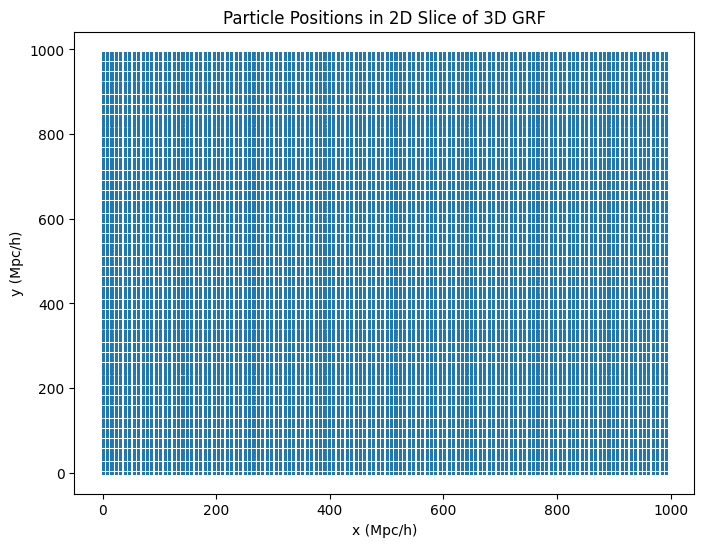

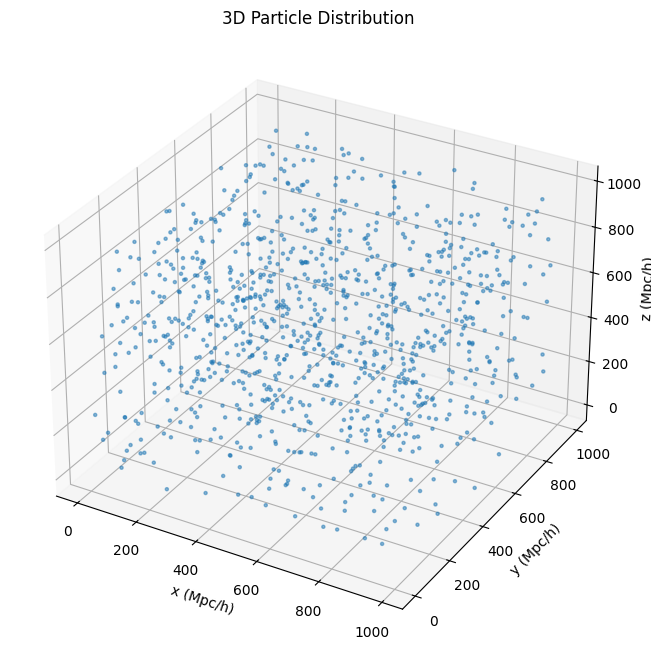

Scale factor a = 0.0100
Growth factor D = 0.0100
Hubble parameter H(a) = 38244.36 km/s/Mpc (proper)
Mean displacement: 0.028778308223585 Mpc/h
Mean velocity: 39.024618356239166 km/s
Max displacement: 0.103811005403554 Mpc/h


In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(positions[:, 0], positions[:, 1], s=1, alpha=0.1)
plt.title(f"Particle Positions in 2D Slice of 3D GRF")
plt.xlabel('x (Mpc/h)')
plt.ylabel('y (Mpc/h)')
plt.show()

subset = np.random.choice(len(positions), 1000, replace=False)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(positions[subset, 0], positions[subset, 1], positions[subset, 2], s=5, alpha=0.5)
ax.set_title(f"3D Particle Distribution")
ax.set_xlabel('x (Mpc/h)')
ax.set_ylabel('y (Mpc/h)')
ax.set_zlabel('z (Mpc/h)')
plt.show()

print(f"Scale factor a = {a:.4f}")
print(f"Growth factor D = {D:.4f}")
print(f"Hubble parameter H(a) = {H:.2f} km/s/Mpc (proper)")
# Since perturbations are tiny at z ~ 99, lets increase the print precision for the means.
print(f"Mean displacement: {np.mean(np.sqrt(np.sum(zeldovich(density_field)**2, axis=0))):.15f} Mpc/h")
print(f"Mean velocity: {np.max(np.sqrt(np.sum(velocities**2, axis=1))):.15f} km/s")
# Checking the max values... should be very small but still non-zero.
print(f"Max displacement: {np.max(np.sqrt(np.sum(zeldovich(density_field)**2, axis=0))):.15f} Mpc/h")

### **CIC (Cloud-in-Cell) Interpolation**

We have successfully generated particle positions from an initial density field, we now have to map these particles (with their mass) onto a continuous density field on a grid, so that we can actually evolve the simulation.

To do this, we can use a technique(s) called *Particle Mesh Method*, which is a class of methods used for determining how the particles evolves given a a density distribution (our overdensity) and potential (in this case, our gravitational potential).

***Particle Mesh (PM):***
  - Originally invented for simulations of compressible fluid flows and collisionless plasma sims in the 50s-60s, it became widely used in the 70s and beyond for 3D cosmological simulations.
  - PMs are widely used in cosmology due to its simplicity and computational speeds, where, given the number of particles N_p and the number of grid cells for the simulation resolution N_c, the time complexity is roughlt O(n_p) + O(N_c ln N_c).
  - Assuming we have particles defined with a certain size, mass shape and internal density, there are three main types of PMs to use:
    - Nearest Grid Point (NGP): in which particles are point-like and all of the particle's mass is assigned to the single grid cell that contains it.
    - Cloud In Cell (CIC): in which particles are in a cloud-like grid (cube in 3D) of uniform density and of one grid cell size and each particle contributes to 8 nearest cells in 3D.
    - Triangular Shaped Cloud (TSC): in which particles are in a triangular shaped grid of uniform density and of one grid cell size and each particle contributes to 27 nearest cells in 3D.

  - We will use CIC interpolation for our simulation.

***CIC:***
  - Remember that our particles represent mass elements displaced from their initial positions via the Zel'dovich Approx. To compute the gravitational forces and evolve the simulation, we need to assign particles masses to the grid points efficiently. Thus, we can do the following:

1. **Identify Parent Cell:**
  - for each particle with coordinates (xp, yp, zp), we can determine the parent cell indices:

    i = [xp], j = [yp], k = [zp], where [x] represents the integer floor function.

  - in our case, we will treat each particle as a 'cloud' with a size equal to the grid cell spacing h, where h in our sim will be L / N.

  - thus, we compute the parent cell indices for each particle via:

    `floor(coodinate / h)`

  - Note: since our simulation uses a periodic box of size L, particle positions exceeding L are wrapped (positions % L) due to periodic boundary conditions. We do this because we want to account for those particles (since the sim is a cube, the particle exceeding L will just be sent from one side to the opposite).

2. **Compute the (normalized) Distances:**
  - Now that we have the parent cell indices, we can now compute the distances (dx, dy, dz) from the particle positions to the cell center (xc, yx, zc), where (xc, yc, zc) is (i,j,k).

  - In our case, we simply divide our original position coords by h, then subtract that from the parent cell indices.

    dx = (xp - xc), dy = (yp - yc), dz = (zp - zc)

3. **Compute the Weights:**
  - We compute the weight for the 8 neighboring grid points. These weights are determined based on the particle's proximity to the neighboring grid points.
  - For each dimension:

    W_p = 1 - d_p, where p is x, y, z respectively.

  - These weights represents the fraction of the particle's mass assigned to the grid points, based on the distance! For each grid point, we can multiply the weights along the 3 dimensions, so that:
  
    W_total = W_x * W_y * W_z

4. **Mass distribution:**
  - We can now assign the particle's mass to the eight neighboring cells using trilinear interpolation (each of the weights * the mass). We can assume the mass per particle is 1 for simplicity. This will result in a grid of densities p_i,j,k.

In [ ]:
def cic_interpolation(positions, N, L):
  # Preliminaries: defining our sim's grid spacing via h, wrapping positions
  # to [0, L) due to periodic boundary conditions.
  h = L/N
  wrapped_pos = positions % L
  xp, yp, zp = wrapped_pos[:, 0]/h, wrapped_pos[:, 1]/h, wrapped_pos[:, 2]/h

  # Using floor function to get the parent cell indices (xc, yc, zc).
  xc, yc, zc = xp.astype(int), yp.astype(int), zp.astype(int)

  # From there, can compute the normalized distances using the parent cell indices.
  dx, dy, dz = xp-xc, yp-yc, zp-zc

  # Now, compute the weights for each dimension. The sum of these will equal 1,
  # essentially preserving the particle's mass.
  tx, ty, tz = 1-dx, 1-dy, 1-dz

  # Given our weights for each dimension, the weights for all 8 neighboring grid
  # points can be determined, since they are products of linear interpolation factors
  # (trilinear).
  w000 = tx * ty * tz
  w100 = dx * ty * tz
  w010 = tx * dy * tz
  w001 = tx * ty * dz
  w110 = dx * dy * tz
  w011 = tx * dy * dz
  w101 = dx * ty * dz
  w111 = dx * dy * dz

  # Now that weights are computed, we can now initialize our density grid.
  density_grid = np.zeros((N, N, N))

  # Can also initialize our grid's indices, using our parent cell indices and
  # ensuring we take into account periodicity.
  i0, i1 = xc % N, (xc+1) % N
  j0, j1 = yc % N, (yc+1) % N
  k0, k1 = zc % N, (zc+1) % N

  # Finally, we will assign the particle's mass to the 8 neighboring grid points
  # For this step, we will assume our particle's mass 'mp' is 1 for simplicity.
  mp = 1
  np.add.at(density_grid, (i0, j0, k0), mp * w000)
  np.add.at(density_grid, (i1, j0, k0), mp * w100)
  np.add.at(density_grid, (i0, j1, k0), mp * w010)
  np.add.at(density_grid, (i0, j0, k1), mp * w001)
  np.add.at(density_grid, (i1, j1, k0), mp * w110)
  np.add.at(density_grid, (i0, j1, k1), mp * w011)
  np.add.at(density_grid, (i1, j0, k1), mp * w101)
  np.add.at(density_grid, (i1, j1, k1), mp * w111)

  # The result is our density grid where each point's value is the total mass
  # assigned to it, based on the weight's contribution at that specific grid point.
  # Remember, the weight is determined by the distance of the particle from that point.
  return density_grid

In [ ]:
# Compute and Normalize the Density Field.
# Our new density grid can now be normalized to a physical density (our overdensity).
density_cic = cic_interpolation(positions, N, L)

# Mean density should be N_part^3 / N^3 particles per grid point. Here N_part = N
mean_density = np.mean(density_cic)
delta_cic = density_cic / mean_density - 1

# The mean density should be close to 1, since N_part = N
print(f"Mean density from CIC (particles per grid point): {mean_density:.3f}")
print(f"Total mass assigned: {np.sum(density_cic):.1f} (should equal N_part^3 = {N**3})")

Mean density from CIC (particles per grid point): 1.000
Total mass assigned: 2097152.0 (should equal N_part^3 = 2097152)


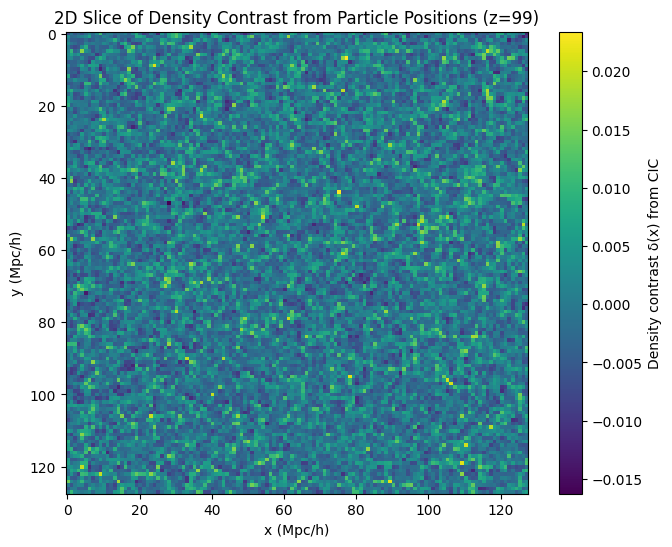

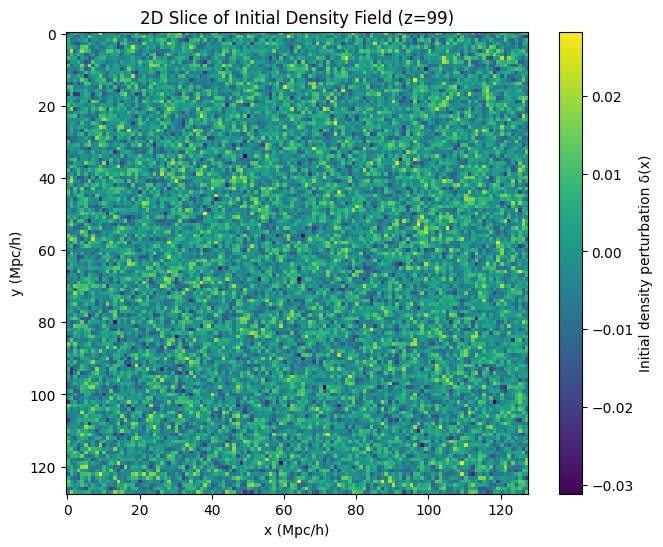

Standard deviation of initial δ: 8.000e-03
Standard deviation of CIC δ: 4.929e-03


In [ ]:
import matplotlib.pyplot as plt  # Already imported, but included for clarity

# Plot a 2D slice of the CIC density contrast
plt.figure(figsize=(8, 6))
plt.imshow(delta_cic[N//2, :, :], cmap='viridis')
plt.colorbar(label='Density contrast δ(x) from CIC')
plt.title('2D Slice of Density Contrast from Particle Positions (z=99)')
plt.xlabel('x (Mpc/h)')
plt.ylabel('y (Mpc/h)')
plt.show()

# Plot the initial density field for comparison
plt.figure(figsize=(8, 6))
plt.imshow(density_field[N//2, :, :], cmap='viridis')
plt.colorbar(label='Initial density perturbation δ(x)')
plt.title('2D Slice of Initial Density Field (z=99)')
plt.xlabel('x (Mpc/h)')
plt.ylabel('y (Mpc/h)')
plt.show()

# Compare statistics
print(f"Standard deviation of initial δ: {np.std(density_field):.3e}")
print(f"Standard deviation of CIC δ: {np.std(delta_cic):.3e}")

In [ ]:
"""
At z=99, the approx is linear, so the density contrast from displaced particles should
be close to the initial. But our results show diff, so must be something wrong.
"""
# Compute Zel'dovich displacements again for inspection
displacements = zeldovich(density_field)
disp_magnitude = np.sqrt(np.sum(displacements**2, axis=0))  # Magnitude per grid point

print(f"Mean displacement: {np.mean(disp_magnitude):.3e} Mpc/h")
print(f"Max displacement: {np.max(disp_magnitude):.3e} Mpc/h")
print(f"Std of displacement magnitude: {np.std(disp_magnitude):.3e} Mpc/h")

# Compare to grid spacing
h = L / N
print(f"Grid spacing h = {h:.3f} Mpc/h")
print(f"Max displacement as fraction of h: {np.max(disp_magnitude) / h:.3e}")

Mean displacement: 2.878e-02 Mpc/h
Max displacement: 1.038e-01 Mpc/h
Std of displacement magnitude: 1.214e-02 Mpc/h
Grid spacing h = 7.812 Mpc/h
Max displacement as fraction of h: 1.329e-02


In [ ]:
# Recompute density_cic for clarity
density_cic = cic_interpolation(positions, N, L)

# Check total mass
total_mass = np.sum(density_cic)
expected_mass = N**3  # Since N_part = N and each particle has mass 1
print(f"Total mass in density_cic: {total_mass:.1f}, Expected: {expected_mass}")

# Check variance before normalization
print(f"Standard deviation of raw density_cic: {np.std(density_cic):.3e}")

# Recalculate delta_cic with explicit mean
mean_density = total_mass / (N**3)  # Should be ~1
delta_cic = density_cic / mean_density - 1
print(f"Recalculated std of delta_cic: {np.std(delta_cic):.3e}")

Total mass in density_cic: 2097152.0, Expected: 2097152
Standard deviation of raw density_cic: 4.929e-03
Recalculated std of delta_cic: 4.929e-03


Correlation between density_field and delta_cic: 0.710


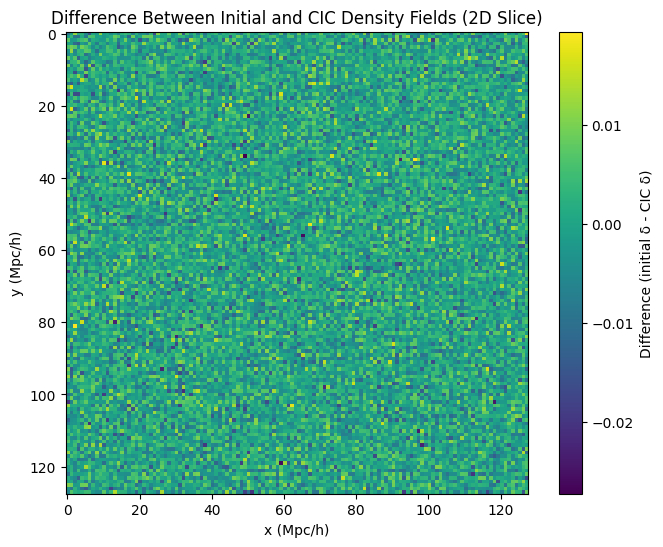

In [ ]:
# Correlation between initial and CIC density fields
correlation = np.corrcoef(density_field.ravel(), delta_cic.ravel())[0, 1]
print(f"Correlation between density_field and delta_cic: {correlation:.3f}")

# Plot difference
plt.figure(figsize=(8, 6))
plt.imshow(density_field[N//2, :, :] - delta_cic[N//2, :, :], cmap='viridis')
plt.colorbar(label='Difference (initial δ - CIC δ)')
plt.title('Difference Between Initial and CIC Density Fields (2D Slice)')
plt.xlabel('x (Mpc/h)')
plt.ylabel('y (Mpc/h)')
plt.show()

### **Computation of the New Gravitational Potential/Forces from CIC Field**

At this point, we have used mapped the displaced particles onto a new density field via the Cloud-In-Cell Interpolation method, which distributes the particles' masses to its neighboring grid points on the field, then normalized that field to get the new density contrast δ.

Now what?
  - Well, we have a new overdensity, so now we have to recompute the graviational potential Φ and subsequent forces Ψ from this overdensity. Then we compute a new CIC to assign the forces onto the particles on the field.

Recall that in the Zel'Dovich Approximation step:

  - we used the initial overdensity computed from the GRF to get the graviational potential Φ via the Poisson Equation: ∇^2ϕ(x)=δ(x). This potential is a scalar field that essentially measures how much gravitational energy exists in each region of the field.
  
  - we subsequently used this potential to get the displacement Ψ, which is a vector field(s) determining how far and in what direction the particles shift from their original positions due to the potential.

Thus, we will do a very similar process in this step. The main difference will be in how we represent our displacement Ψ. In this case, Ψ will not be represented as the 'displacement field' but rather the **'gravitational forces'**
 (acceleration fields) in each respective directions.

After these are computed, we will do another CIC Interpolation, but will also be slightly different from the initial CIC. Lets explain the difference:

***CIC for Density Assignment:*** This represents our initial CIC from the previous step, and is a particle-to-grid operation. We took each of our particle's mass and distributed to its 8 surrounding grid points on a new grid, weighted by how close it is to each one (this can be visualized as a 'scattering' of the particle's contribution to each of the grid points). This results in our CIC grid/field which becomes our new overdensity.

***CIC for Force Assignment:*** This new CIC process is different from the aformentioned one because its a grid-to-particle operation. We take our forces computed from our new gravitational potential derived from the CIC grid/field and assign them to each of the particles. This time, each particle's acceleration is the weighted average of the forces at the 8 surrounding grid points (this can be visualized as a 'gathering' of the grid's forces to the particle).

  - Why interpolate forces to the particle positions? We do this because we have to update the particles velocities and positions using the acceleration at its current location! We interpolate the force components to each of the particles positions to get its acceleration. This gives each particle a tailored acceleration based on its location relative to the overdensities.

Thus, these CIC interpolation are *inverse* processes! The Density Assignment process is only done once, the Force Assignment is done each time we run our simulation for a certain number of timesteps, via the leapfrog integration which will be implemented in the next step. This is how we evolve our simulation!

Here are the following steps to achieve this:
  

1. **Compute the wavenumber grid if not already available:**

  - Recall, we do this during the Zel'Dovich Approx. We do our computation in Fourier Space via FFT for more efficient computation of the potential and forces.

In [ ]:
# Define the wavenumber grids in Fourier space
k_coords = np.fft.fftfreq(N) * N * k0
kx, ky, kz = np.meshgrid(k_coords, k_coords, k_coords, indexing='ij')
k2 = kx**2 + ky**2 + kz**2
k2[0,0,0] = 1.0  # Avoid division by zero at k=0

2. **Solve Poisson Equation for the potential Φ:**

  - Using the normalized new density field `delta_cic`, can compute the new potential in Fourier Space.
  - δ(k): ∇²φ = δ ===> φ(k) = -δ(k)/k²

In [ ]:
# Transforming the new overdensity into fourier space.
delta_cic_k = np.fft.fftn(delta_cic)

# Computation of the graviational potential.
potential_cic_k = -delta_cic_k/k2
potential_cic_k[0,0,0] = 0

3. **Computing the force fields Ψ (displacements):**

  - Same process as the displacement computation: since its the negative gradient of the potential Φ, do simple differentiation in Fourier Space for each direction, then transform each back into Real Space.
  - Ψ = -∇φ, ===> Ψ_i(k) = -i * k_i φ(k)

In [ ]:
force_x_k = -1j * kx * potential_cic_k
force_y_k = -1j * ky * potential_cic_k
force_z_k = -1j * kz * potential_cic_k

# Transforming back to real.
force_x = np.real(np.fft.ifftn(force_x_k))
force_y = np.real(np.fft.ifftn(force_y_k))
force_z = np.real(np.fft.ifftn(force_z_k))

4. **Interpolating the forces (displacements) to the particle positions:**

As explained above, this part deviates from the initial CIC interpolation in the following way:
  - In this CIC interpolation, instead of distributing the particles mass along its 8 neighboring grid points on a new density field we will interpolate the computed forces in each direction to each particle's position in order to get their accelerations in each direction (remember: grid-to-particle operation, not particle-to-grid!).

Thus, we will start with our preliminaries:
  - Initialization of grid spacing and subsequent wrapping of positions to [0, L) to handle periodic boundary conditions, resulting in the particles' coordinates (xp, yp, zp).
  - Getting the parent cell indices via the integer floor function applied to the particles' coords to get its coordinates (xc, yc, zc).
  - Computation of our normalized distances from the parent cell indices to get (dx, dy, dz), followed by weight computation at each direction, from the normalized distances to get (tx, ty, tz).
  - Also, initialization of the grid cell indices via the parent cell indices, taking into account periodic boundary conditions to get (i0, i1), (j0, j1), (k0, k1).

Now, here come change up:
  - We fetch the force field values at the 8 neighboring grid points via the usage of our grid cell indices to get our 8 field values f000 through f111.
  - From here, we do the trilinear interpolation. In this case, since we want to assign the acceleration for each particle, we do the weighted average of the field values at the 8 neighboring points. Thus, we multiply the field values with its respective weight that corresponds to that value, and do the summation for all 8.
  - The result is the accelerational force for each particle at that specified direction. We do this operation for all 3 force components (x, y, z), and then combine the three into a single array.


In [ ]:
def cic_force_interp(field, positions, N , L):
  h = L / N
  wrapped_pos = positions % L
  xp, yp, zp = wrapped_pos[:, 0]/h, wrapped_pos[:, 1]/h, wrapped_pos[:, 2]/h
  xc, yc, zc = np.floor(xp).astype(int), np.floor(yp).astype(int), np.floor(zp).astype(int)
  dx, dy, dz = xp-xc, yp-yc, zp-zc
  tx, ty, tz = 1-dx, 1-dy, 1-dz
  # Grid cell indices via our parent cell indices, taking into account periodic boundary conds.
  i0, i1 = xc % N, (xc+1) % N
  j0, j1 = yc % N, (yc+1) % N
  k0, k1 = zc % N, (zc+1) % N

  # Now, difference bw this interpolation and the initial cic is that this one takes the
  # forces computed for each direction, and assign them to the particles thats on the grid
  # The initial cic simply assigned the particle masses on to the grid. Its the opposite.

  # Fetching the field values at the 8 neighboring grid points.
  f000 = field[i0, j0, k0]
  f100 = field[i1, j0, k0]
  f010 = field[i0, j1, k0]
  f001 = field[i0, j0, k1]
  f110 = field[i1, j1, k0]
  f011 = field[i0, j1, k1]
  f101 = field[i1, j0, k1]
  f111 = field[i1, j1, k1]

  # Then, do the obvious trilinear interpolation. In this case, we are getting the
  # acceleration for each particle, whereby each particle's acceleration is a weighted
  # avg of the forces at the 8 neighboring grid points. (gathering the grid's forces
  # to the particle)
  interpolated = (
    f000 * tx * ty * tz +
    f100 * dx * ty * tz +
    f010 * tx * dy * tz +
    f001 * tx * ty * dz +
    f110 * dx * dy * tz +
    f011 * tx * dy * dz +
    f101 * dx * ty * dz +
    f111 * dx * dy * dz
  )
  return interpolated

# Computation of the acceleration for each particle.
accel_x = cic_force_interp(force_x, positions, N, L)
accel_y = cic_force_interp(force_y, positions, N, L)
accel_z = cic_force_interp(force_z, positions, N, L)

# Combining the accelerations into a single array.
accelerations = np.stack([accel_x, accel_y, accel_z], axis=1)
print(f"Accelerations shape: {accelerations.shape}")
print(accelerations)

Accelerations shape: (2097152, 3)
[[ 0.01610151 -0.00800099 -0.01945929]
 [ 0.01296537 -0.01817243 -0.01071768]
 [ 0.00922592 -0.02490604  0.00539605]
 ...
 [ 0.02887108 -0.01752523 -0.00890644]
 [ 0.02903083 -0.01411153 -0.00312956]
 [ 0.03583929 -0.02159989 -0.02531242]]


In [ ]:
# Now, lets check the accelerations's magnitudes.
# Note, these are still in simulation (comoving) units, needs to be converted to physical units.
accel_magnitude = np.sqrt(np.sum(accelerations**2, axis=1))
print(f"Mean acceleration: {np.mean(accel_magnitude):.3e} (simulation units)")
print(f"Max acceleration: {np.max(accel_magnitude):.3e} (simulation units)")

Mean acceleration: 2.290e-02 (simulation units)
Max acceleration: 9.463e-02 (simulation units)


Now, we know how much accelerational force is experienced by our particles in our density field!

Our accelerations are in *simulation units* (Mpc/h) since its computed in comoving coordinates, not physical coordinates. We will handle this accordingly in the next step, since it have to be in physical units to update the velocities and positions based on the acceleration in our simulation.

Mean acceleration:
  - At redshift z=99, the universe is very smooth (small density perturbations), and since gravitational accelerations scale with these perturbations, the mean acceleration will be relatively small.

Max acceleration:
  - Representing the largest acceleration any particle experiences as of this point, it is ~ 4 times larger than the mean, suggesting these region(s) in the field have higher density contrasts leading to stronger gravitational pulls towards said region(s).

**Visualizations:**

Lets visualize our accelerations to see how our accelerational forces interact with the particles.

***2D Scatter with Acceleration Vectors:***
  - Quiver plot of a 2D slice of the particle positions, showing how the accelerations relate to the particles' positions. Sliced near the middle of the field.

***3D Scatter with Acceleration Vectors:***
  - Usage of a subset of the particles for clarity, can see the spatial distribution of the particles.

***2D Acceleration Map:***
  - Grids the acceleration magnitudes and plot them on a heatmap, showing regions of strong vs weak gravitational influences on the particles.

***Histogram of Acceleration Magnitudes:***
  - Displays how the accelerations are statistically distributed across all particles.

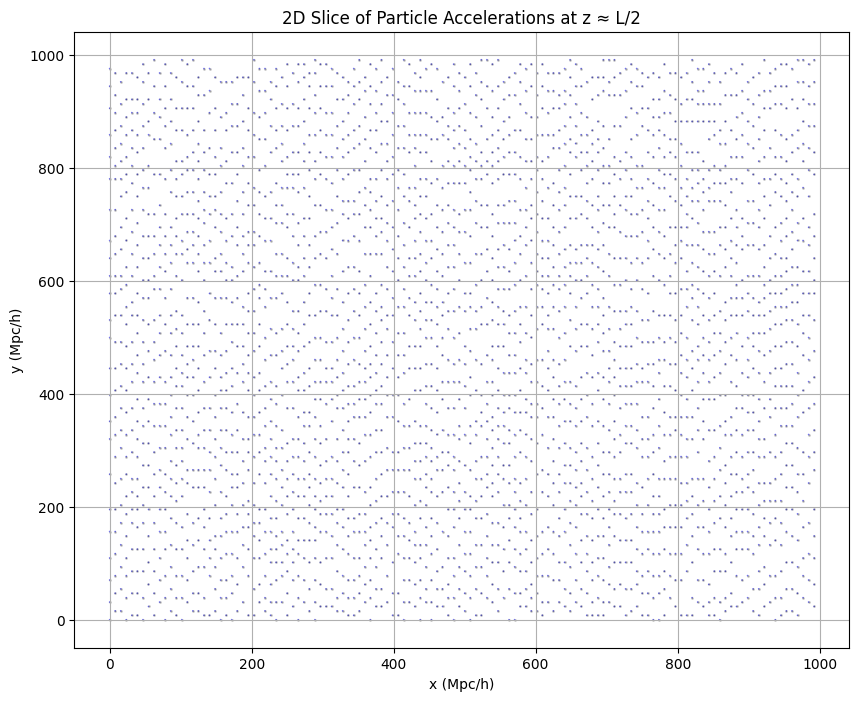

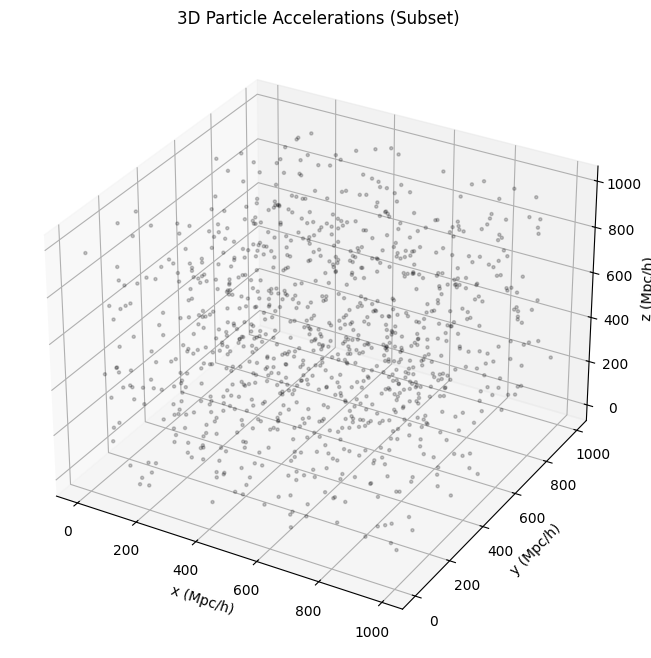

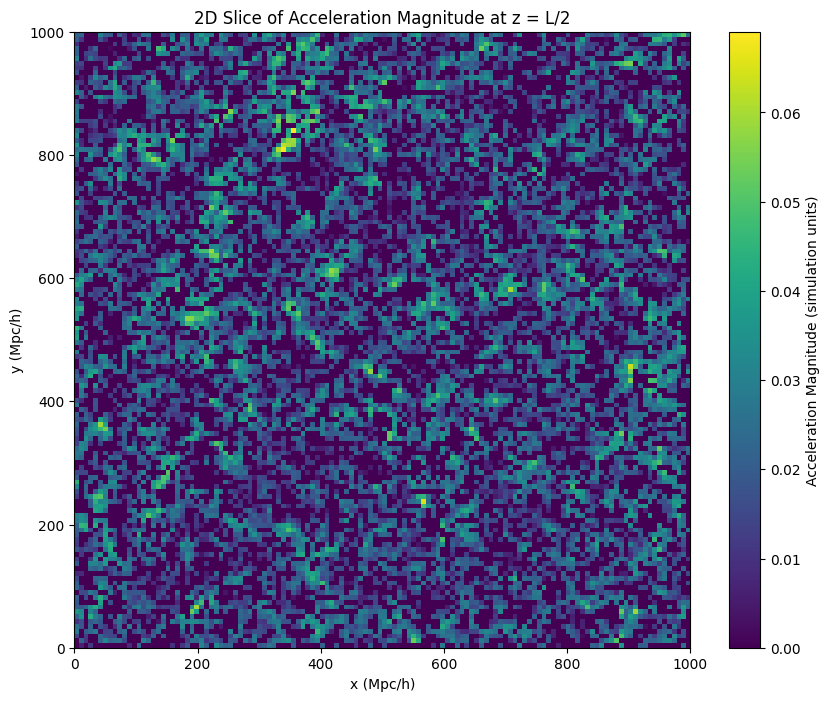

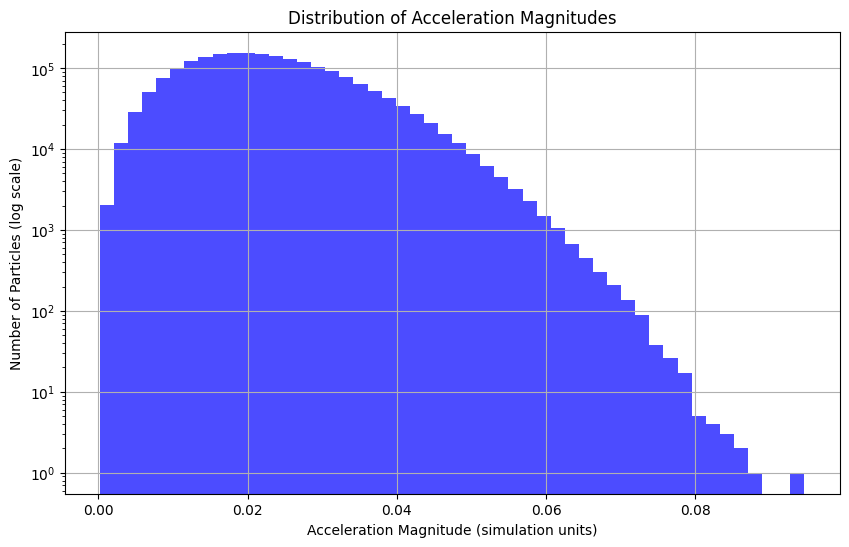

In [ ]:
# Visualizations:

# 2D Scatter with Acceleration Vectors (Quiver Plot):
# Select a 2D slice (e.g., particles near z = L/2)
slice_thickness = L / N  # Grid spacing
z_center = L / 2
mask = (positions[:, 2] > z_center - slice_thickness) & (positions[:, 2] < z_center + slice_thickness)
slice_positions = positions[mask]
slice_accels = accelerations[mask]

# Downsample for clarity (optional, e.g., take every 10th particle)
step = 10
x = slice_positions[::step, 0]
y = slice_positions[::step, 1]
u = slice_accels[::step, 0]  # x-component of acceleration
v = slice_accels[::step, 1]  # y-component

# Create the quiver plot
plt.figure(figsize=(10, 8))
plt.quiver(x, y, u, v, scale=1.0, scale_units='xy', angles='xy', color='blue', alpha=0.5)
plt.scatter(x, y, s=1, color='black', alpha=0.2)  # Particle positions as background
plt.title('2D Slice of Particle Accelerations at z ≈ L/2')
plt.xlabel('x (Mpc/h)')
plt.ylabel('y (Mpc/h)')
plt.grid(True)
plt.show()

# 3D Scatter with Acceleration Vectors:
# Subset of particles (e.g., 1000 random ones)
n_subset = 1000
indices = np.random.choice(len(positions), n_subset, replace=False)
subset_pos = positions[indices]
subset_acc = accelerations[indices]

# Create the 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.quiver(subset_pos[:, 0], subset_pos[:, 1], subset_pos[:, 2],
          subset_acc[:, 0], subset_acc[:, 1], subset_acc[:, 2],
          length=1.0, normalize=False, color='blue', alpha=0.5)
ax.scatter(subset_pos[:, 0], subset_pos[:, 1], subset_pos[:, 2], s=5, color='black', alpha=0.2)
ax.set_title('3D Particle Accelerations (Subset)')
ax.set_xlabel('x (Mpc/h)')
ax.set_ylabel('y (Mpc/h)')
ax.set_zlabel('z (Mpc/h)')
plt.show()

# 2D Acceleration Magnitude Map:
# Compute acceleration magnitudes
accel_magnitude = np.sqrt(np.sum(accelerations**2, axis=1))

# Define a function to grid the magnitudes (similar to CIC but simpler averaging)
def grid_magnitudes(positions, magnitudes, N, L):
    h = L / N
    grid = np.zeros((N, N, N))
    counts = np.zeros((N, N, N))
    indices = (positions / h).astype(int) % N  # Grid indices with periodic boundaries
    np.add.at(grid, (indices[:, 0], indices[:, 1], indices[:, 2]), magnitudes)
    np.add.at(counts, (indices[:, 0], indices[:, 1], indices[:, 2]), 1)
    counts[counts == 0] = 1  # Avoid division by zero
    return grid / counts

# Grid the acceleration magnitudes
accel_grid = grid_magnitudes(positions, accel_magnitude, N, L)

# Plot a 2D slice
plt.figure(figsize=(10, 8))
plt.imshow(accel_grid[N//2, :, :], cmap='viridis', extent=[0, L, 0, L])
plt.colorbar(label='Acceleration Magnitude (simulation units)')
plt.title('2D Slice of Acceleration Magnitude at z = L/2')
plt.xlabel('x (Mpc/h)')
plt.ylabel('y (Mpc/h)')
plt.show()

# Histogram of the Acceleration Magnitudes:
# Compute acceleration magnitudes (if not already done)
accel_magnitude = np.sqrt(np.sum(accelerations**2, axis=1))

# Create the histogram
plt.figure(figsize=(10, 6))
plt.hist(accel_magnitude, bins=50, log=True, color='blue', alpha=0.7)
plt.title('Distribution of Acceleration Magnitudes')
plt.xlabel('Acceleration Magnitude (simulation units)')
plt.ylabel('Number of Particles (log scale)')
plt.grid(True)
plt.show()


What does the plot(s) tell us?:

  - ***2D Scatter with Acceleration Vectors:***
    - Displays a grid-like formation of the particles, which makes sense because the particles are initialized on grid uniformly.
    - Small zigzag patterns can be seen, meaning the particles are being slightly displaced due to the early gravity perturbations.
    - No major clustering, which is good because we are starting at z99 where the formations are just beginning.

  - ***3D Scatter with Acceleration Vectors:***
    - Displays a 3D plot of a small subset of the particles within the simulation.
    - Small displacements shown here as well, particles are mostly uniform, although some small clustering is forming. This is good since starting at z=99.
  
  - ***2D Acceleration Map:***
    - Shows a 2D heatmap of the acceleration magnitudes, where low acceleration regions in darker shade, higher acceleration regions in lighter shade.
    - Small scattered higher accel regions, which makes sense because at this point, the overdensities are relatively small.

  - ***Histogram of Acceleration Magnitudes:***
    - Displays a histogram of the distribution of the accel magnitudes for all the particles.
    - Skews left, meaning most particles has small accelerations, which makes sense due to our mean and max acceleration magnitudes, and the universe at this point has near uniform density.
    - Weak forces at this point in time dominates, and stronger forces are smaller in number but are expected to grow.

In the context of our sim, these results are just as expected!

Now, lets use these accelerations to update the particles positions and velocities at each timestep via the Leapfrog Integration:

### **Leapfrog Integration**

Based on our particle accelerations, we can update the particles for a certain number of timesteps via the ***leapfrog integration.*** What is it?:

  - Its a numerical method used to solve ordinary differential equations (ODEs), particularly 2nd order ODEs like those describing motion (our mesh simulation for instance).
  - Its a ***symplectic*** integrator, meaning it preserves the underlying structures of the equations used and conserves energy over long-timescales, making it better than 1st order methods like euler's method.

Lets explain the process:

The central goal of the leapfrog integration is computing our *positions x(t)* and *velocities v(t)* over time numerically, given the initial conditions and a small timestep we can denote as *timestep Δt*.

Lets say we are given a time *t, x(t)*, and *v(t)*. Since our goal is finding their values at a small interval in time, *t + Δt*, we can do the Taylor Expansion of the this change:

$$
x(t + \Delta t) = x(t) + v(t)\Delta t + \frac{1}{2}a(t)\Delta t^2 + \frac{1}{6}\frac{da}{dt}(t)\Delta t^3 + O(\Delta t^4)
$$

$$
v(t + \Delta t) = v(t) + a(t)\Delta t + \frac{1}{2}\frac{da}{dt}(t)\Delta t^2 + O(\Delta t^3)
$$

We can implement the ***Euler's Method,*** which approximates:

$$
x_{n+1} = x_n + v_n Δ t
$$

$$
v_{n+1} = v_n + a(x_n)\Delta t
$$

This is a simple approximation that updates the positions and velocities, but the issue with this method is:
  - its only 1st order accurate, meaning its error is: $ O(Δ t^2)$
  - prone to energy drift and instability, thus is non-symplectic.

We can improve this by making sure our integration aims for 2nd order accuracy and better enetgy conservation. Lets propose the ***Verlet Method,*** shown to be more symmetric and accurate:
  - Forward taylor:
$$
x(t+\Delta t) = x(t) + v(t)\Delta t + \frac{1}{2}a(t)\Delta t^2 + O(\Delta t^3)
$$

  - Backward taylor:
$$
x(t-\Delta t) = x(t) - v(t)\Delta t + \frac{1}{2}a(t)\Delta t^2 + O(\Delta t^3)
$$

  - Summation of both:
$$
x(t+\Delta t) + x(t-\Delta t) = 2x(t) + a(t)\Delta t^2 + O(\Delta t^3)
$$

  - Rearrange:
$$
x(t+\Delta t) = 2x(t) - x(t-\Delta t) + a(t)\Delta t^2 + O(\Delta t^3)
$$

  - Thus, position change will be the following:
$$
x_{n+1} = 2x_n - x_{n-1} + a_n\Delta t^2
$$

The above is the ***position verlet formula***, accurate to the 2nd order (error $O(Δ t^3)$), but the issue with this method is:
  - requires knowing the positions at the two previous timesteps (current position as well as the position before that) and does not explicitly update the velocity!
  - since we only have the position and velocities at the current timestep and want to update them, we have to modify this method to work with the velocity explicitly.
  
In comes the ***Leapfrog Method:***

  - Updating the positions and velocities in a 'staggered' way for stability, via a ***Kick-Drift-Kick (KDK) Scheme*** that allows us to work with our velocities explicitly by defining them at half timesteps *t + Δt/2:* Its called leapfrog because the half-step velocities and full-step positions leap over each other over time!

  1. ***Kick:*** Updating the velocities by a half timestep using the current acceleration.

$$
v_{n+1/2} = v_n + a(x_n) \frac{\Delta t}{2}
$$

  2. ***Drift:*** Updating the positions bt a full timestep using the half-step velocities.

$$
x_{n+1} = x_n + v_{n+1/2} \Delta t
$$


  3. ***Kick:*** Updating the velocities and by another half timestep using the new acceleration computed at the new positions.

$$
v_{n+1} = v_{n+1/2} + a(x_{n+1}) \frac{\Delta t}{2}
$$

This method will make more sense once we implement it, but for simplicity, it works well because not only are we updating the velocity and positions, but its also 2nd order accurate. We can prove this by substituting the half-step velocity into the position update like this:

$$
x_{n+1} = x_n + \left(v_n + a(x_n) \frac{\Delta t}{2}\right)\Delta t = x_n + v_n \Delta t + \frac{1}{2}a(x_n)\Delta t^2
$$

It matches the taylor expansion up to $Δt^2$, confirming 2nd order accuracy, error $O(Δ t^3)$. So we have essentially solved accuracy issue within euler's method, as well as the the non-explicit velocity update issue in the verlet method!

Lets now implement this integration:

1. **Parameter Setup:**

  First, we will set up our parameters for usage. We need:
  - **delta_t:** Representing the timestep, measured in million year (Myr).
  - **num_steps:** Representing the number of timesteps for our simulation.

  Some important cosmological params will be used as well, including:
  - **a_current:** The initial scaling factor. This will subsequently be updated for each timestep.
  - **H_current:** The initial Hubble Parameter, in *km/s/Mpc.*
  - **H0:** The current Hubble Constant, also measured in *km/s/Mpc.*
  - **omega_m:** The mass density parameter at current redshift (z=0).

In [ ]:
# Timestep, measured in million year (Myr), as well as the number of timesteps.
delta_t = 0.1
num_steps = 500

# Initial Cosmological parameters for usage.
a_current = a
H_current = H # the initial hubble parameter in km/Mpc
H0 = Planck18.H0.value
omega_m = Planck18.Om0

2. **Conversion and Acceleration Factor:**

  Perhaps the most important of the integration step! In order to update our positions and velocities, they need to be in physcical units, and not our current simulation units. Lets explain why:

  ***Comoving coordinates (x):***
  - This is the coordinate system we have been working with so far. This system compose of coordinates that expands with the universe. As the space expands, the grid expands, and so the comoving coords of the points on the grid remain constant. In our sim, we denote this as *x* like in our zeldovich initial conditions (lagrangian coords). Our sim is in comoving Mpc/h.

  ***Comoving Velocity:***
  - This is the velocity of a particle relative to the expanding comoving grid. In a perfectly homogeneous and isotropic expanding universe, the particles at rest in comoving coordinates will remain at rest (its position) in comoving coords, but their physical positions would change due to the expansion. Thus, a velocity thats 0 in comoving coords means that the particle is just being carried by the hubble flow (expansion)!

  ***Physical (proper) coordinates (r):***
  - The actual physical distances in the universe, at a given time. They are related to the comoving coords via the scaling factor *a(t)*, thus: $$ r(t) = a(t) * x $$

  - meaning that the comoving coords are related to the physical via the scaling factor *1/a(t)*, thus: $$ x = r(t) * 1/a(t)$$

  ***Peculiar velocity (v_pec):***
  - This is the velocity relative to the hubble flow at its location, meaning its the velocity in addition to the velocity due to the universe's expansion. These velocities arise due to the gravitational forces from the density contrasts. Since the particles are being pulled towards overdense regions and away from the underdense ones, they are moving relative to the smooth hubble expansion. This is the velocity computed from our initial density field!

  **Peculiar acceleration (a_grav):**
  - This is the gravitation forces that causes the deviations from the uniform hubble expansion, which are derived from the density perturbations from the CIC density field, and then scaled by the cosmological scale to convert it to a physical gravitational acceleration.

  Our simulation involves:
  - **positions (x):** comoving coordinates in Mpc/h
  - **velocities (v_pec):** the peculiar velocities in km/s. This was computed in the initial velocities calculation via the zeldovich approx. Its the velocities of the particles in addition to the hubble flow at starting redshift.
  - **time (t):** the time, measured in Myr, with our Δt being 0.1 Myr.
  - **g:** the dimensionless acceleration (in terms of physical units). This is the result of our CIC force interpolation step in which we computed the accelerations to be assigned to the particles in each direction. It essentially represents the acceleration in the comoving frame due to gravity (Mpc/h), but its not yet in physical units of acceleration (peculiar).

  ***Cosmological Scaling:***
  - Actually facilitates the conversion of the dimensionless acceleration *g* to the physical peculiar acceleration.
  - Derived from solving poisson's equation in comoving coordinates. which is defined as the following:

$$
\nabla_x^2 \phi = 4\pi G \bar{\rho} a^2 \delta
$$

  - We must relate the comoving potential here to the physical density, since we are working on physical densities in our simulation, so we compute the mean (background matter) density using the 1st Friedmann Equation so that we can show how the matter density evolves with the expansion of the universe:

$$
\rho_\text{bg} = \frac{3H_0^2 \Omega_m}{8\pi G a^3}
$$

  - From there, we substitute this into our original poisson to get the poisson that accounts for the expansion of the universe and matter density!

$$
\nabla^2 \phi_\text{standard} = \frac{3}{2} \frac{\Omega_m H_0^2}{a} \delta,
$$


  - Now, we know that due to the relationship between the physical and comoving coordinates, we must scale our Φ such that our physical gravitational acceleration a_grav is the $-∇Φ$ is scaled by $-1/a$:

$$
\mathbf{a}_\text{grav} = -1/a \nabla \phi
$$

  - In our simulation, our poisson is related to our overdensity via:

$$
\nabla^2 \phi = \delta
$$

  - So, we must equate our Φ with the Φ_standard in the poisson equation we derived that relates to the physical density.

$$
\phi_{\text{your}} = \frac{\phi_{\text{standard}}}{\left( \frac{3}{2} \, \frac{\Omega_m H_0^2}{a} \right)}
$$

$$
\mathbf{g} = -\nabla \phi_{\text{your}} = -\nabla \phi_{\text{standard}} \cdot \left( \frac{3}{2} \, \frac{\Omega_m H_0^2}{a} \right)
$$

$$
\mathbf{g} = - \left( \frac{3}{2} \, \frac{\Omega_m H_0^2}{a} \right) \nabla \phi_{\text{standard}}
$$

$$
\mathbf{a}_{\text{grav}} = -\frac{1}{a} \nabla \phi_{\text{standard}} = \left( \frac{3}{2} \, \frac{\Omega_m H_0^2}{a} \right) \cdot \frac{1}{a} \, \mathbf{g}
$$

$$
\mathbf{a}_{\text{grav}} = \frac{3}{2} \Omega_m H_0^2 \cdot \frac{1}{a^2} \, \mathbf{g}
$$



  - Thus, given the dimensionless acceleration *g* (Mpc/h) to be exact, we can multiply *g* with this ***acceleration factor*** derived from the poisson equation that reflects the matter density's gravitational effect diluted by the expansion 1/a, which is then multipled with another 1/a scale so that the comoving gradient *g* is convered to its physical counterpart (accounting for the stretching of space) $\frac{3}{2} \Omega_m H_0^2 \cdot \frac{1}{a^2}$

  - $\frac{3}{2} \Omega_m H_0^2 \cdot \frac{1}{a^2}$ is in the units $(km/s)^2$ * $Mpc^2$, which facilitates the physical conversion.

  - This cosmological scaling therefore transform *g* in Mpc/h to $(km/s)^2 / (Mpc/h)$

***Conversion Factor:***
- Finally, we need another conversion factor to convert our physical gravitational acceleration into time units which is needed for the leapfrog integration! Remember, since we are using timesteps $Δt$ to evolve the simulation, our components should reflect this.
- We need our acceleration to be in $(km/s)/Myr$, so we need a timeunit.
- Using simple dimensional anaylsis, we find that our conversion value 1.45e6 can convert our acceleration to its time unit equivalent.
  - conversion: $1Mpc/h per Myr$ = 1.45e6 km/s
 Now, our acceleration is physical and time oriented!

In [ ]:
# Conversion factor: Needed to convert the acceleration's magnitude from simulation
# (comoving) units to physical units. 1 Mpc/h per Myr = 1.45e6 km/s
conversion = 1.45e6
# The scaling factor for the acceleration based on the cosmo params at the current scale
# factor. Combines the cosmological sclaing with the unit conversion to scale the acceleration
# field to (km/s)/Myr.
accel_factor = (3 * H0**2 * omega_m) / (2 * a_current**2) * conversion

3. **Computation of the physical acceleratiaon:**

  Using our accleration factor for acceleration conversion, we can create a function that takes in our positions, grid parameters, as well as our scaling factor and accel factor. Then:

  - Get the CIC density grid via CIC density interpolation.
  - Normalize the grid to get the overdensity  δ.
  - Use poisson to get the new gravitational potential and forces from the new  δ.
  - For each force component, use the CIC force interpolation to get the particles accelerations in each direction.
  - Stack the directional accelerations to get the total dimensionless acceleration.
  - Apply the acceleration factor to convert it from dimensionless to a physical gravitational acceleration.
  
  The result will be the accelerations in units $(km/s/Myr)$. The function will be called for each timestep in the leapfrog integration in order to get the new acceleration from the new position.


In [ ]:
# Function to compute accelerations with cosmological scaling
def compute_accelerations(positions, N, L, a_current, accel_factor):
    density_cic = cic_interpolation(positions, N, L)
    mean_density = np.mean(density_cic)
    delta_cic = density_cic / mean_density - 1
    delta_cic_k = np.fft.fftn(delta_cic)
    potential_cic_k = -delta_cic_k / k2
    potential_cic_k[0,0,0] = 0
    force_x_k = -1j * kx * potential_cic_k
    force_y_k = -1j * ky * potential_cic_k
    force_z_k = -1j * kz * potential_cic_k
    force_x = np.real(np.fft.ifftn(force_x_k))
    force_y = np.real(np.fft.ifftn(force_y_k))
    force_z = np.real(np.fft.ifftn(force_z_k))
    accel_x = cic_force_interp(force_x, positions, N, L)
    accel_y = cic_force_interp(force_y, positions, N, L)
    accel_z = cic_force_interp(force_z, positions, N, L)
    accelerations = np.stack([accel_x, accel_y, accel_z], axis=1)
    # Apply cosmological scaling: a_pec = (3 H0^2 Omega_m / 2 a^2) * g
    accelerations *= accel_factor
    return accelerations

print(f"Timestep: {delta_t} Myr")
print(f"Number of steps: {num_steps}")
print(f"Initial scale factor a: {a_current:.4f}")
print(f"Initial Hubble parameter H: {H_current:.2f} km/s/Mpc")
print(f"Acceleration factor: {accel_factor:.3e} (km/s)/Myr per (Mpc/h)")

Timestep: 10 Myr
Number of steps: 100
Initial scale factor a: 0.0100
Initial Hubble parameter H: 38244.36 km/s/Mpc
Acceleration factor: 3.083e+13 (km/s)/Myr per (Mpc/h)


To do the integration effectively, we can:

  - Create an array that will store the history of the positions at each timestep (will prove to be useful when doing subsequent visualizations).
  - Initializations of the current positions and velocities, which are copies of the initial ones from the Zel'dovich's approx.

Then we use the accelerations function to get the accelerations from the current position.

In [ ]:
positions_history = [positions.copy()]
velocities_current = velocities.copy()
positions_current = positions.copy()
accelerations = compute_accelerations(positions_current, N, L, a_current, accel_factor)

4. **Leapfrog Integration:**
  
**Kick1** (Half-step velocity): Updates the velocities by half a timestep using the current acceleration term.
  - Uses a conversion factor into physical time units $1/Myr$ for the current Hubble param $H$ to facilitate the velocity update.
  - Computation of the total acceleration for the velocity update, formally. defined as:

$$
\mathbf{a}_\text{pec} = -Hv_\text{pec} + a_\text{grav}
$$
  - where $-Hv_\text{pec}$ is the Hubble drag term, representing the effect of the expanding universe slowing down the peculiar velocities. Since $a_grav$ is in $km/s/Myr$ units, this term will also be in these units, thanks to the conversion factor for $H$ and the velocity being $km/s$.
  - the peculiar velocity update at half timestep is thus:

$$
v_\text{pec_n+1/2} = v_\text{pec_n} + a_\text{pec}(x_n) \frac{\Delta t}{2}
$$
    
**Drift** (Full-step positions): Updates the positions be a full timestep using the half-step velocities.
  - Make sure we handle periodic boundary conditions on the positions, as well as scaling the velocities.
  - Computationally, position update is defined as:

$$
x_\text{n+1} = x_n + \frac{v_\text{pec_n+1/2}}{a} \Delta t
$$
- where we scale our peculiar velocities by $1/a$ since v_pec relates to the comoving velocity via this factor.
- conversion factor for the position update, since the current position is in the dimensionless units $Mpc/h$. Since we have a conversion factor that changes from comoving to physical and we need to go back to comoving, just use the inverse of the conversion factor.

**Cosomology Param Updates, Computing new Accelerations:** We have to adjust the current scaling factor and hubble param for the next timestep.
  - The new scaling factor can be defined as:

$$
a_\text{new} = a_\text{current} + Ha_\text{current}Δt
$$
  - this new scaling factor has to be dimensionless, so we can use our converted $H$, which is in $1/Myr$ so that the time unit is canceled out.
  - Updating of $H$ as well. Since the Hubble param is based on the redshift z, which is defined from the scaling factor, we can simply update the z from the new scaling factor and then use the updated z to get the new Hubble.

$$
H_\text{new} = \frac{H(z)}{a}, a = \frac{1}{1+z}
$$
$$
z_\text{new} = \frac{1}{a_\text{new} - 1}
$$

  - then, can compute the new gravitational accelerations $a_\text{grav}$ at new position. This acceleration will be used for the final half-step velocity update.

**Kick2** (Half-step velocity): Updates the velocities by another half timestep with the new accelerations computed from the new positions.

$$
v_\text{pec_n+1} = v_\text{n+1/2} + a_\text{pec}(x_{n+1}) \frac{\Delta t}{2}
$$
  - storing the current particle positions to the positions history array for later usage.

In [ ]:
for step in range(num_steps):
  # Kick: Updating the velocities by half-timestep.
  H_Myr = H_current * 1.0227e-6 # Conversion of H (km/s/Mpc) to 1/Myr
  accel_term = -(H_Myr * velocities_current) + accelerations # (km/s/Myr)
  velocities_current += accel_term * (delta_t / 2)

  # Drift: Updating the positions by a full-timestep.
  # velocities currently in km/s, delta_t is in Myr
  # positions_current will be in km/s * Myr, but has to be converted back to
  # Mpc/h.
  # since our conversion term 1.45e6 km/s is 1Mpc/h/Myr, then 1 km/s = 1Mpc/h/Myr / 1.45e6
  # therefore: (km/s) * Myr = (1Mpc/h/Myr) / 1.45e6 * Myr = 1/1.45e6 * Mpc/h
  position_conversion = 1/conversion
  positions_current += (velocities_current / a_current) * delta_t * (position_conversion)
  positions_current %= L # To handlle our periodic boundary conditions.

  # Updating the scaling factor (simple approximation)
  # new a = a + H * a * delta_t
  # Have to make sure our scaling factor is dimensionless. Thus, must use a conversion factor.
  # Can use H_Myr conversion factor to make a dimensionless.
  a_current += H_Myr * a_current * delta_t

  # Now, lets update the Hubble parameter.
  H_current = Planck18.H(1/a_current - 1).value

  # Now, in order to do the final step to update the velocities again, must compute the
  # new accelerations, which uses the new scaling factor and positions.
  accel_factor = (3 * H0**2 * omega_m) / (2 * a_current**2) * conversion
  accelerations = compute_accelerations(positions_current, N, L, a_current, accel_factor)

  # Kick: Updating the velocities by another half-timestep.
  H_Myr = H_current * 1.0227e-6
  accel_term = -(H_Myr * velocities_current) + accelerations
  velocities_current += accel_term * (delta_t / 2)

  # Storing the positions to be used for the next timestep.
  positions_history.append(positions_current.copy())

  print(f"Step {step+1}: a = {a_current:.6f}, H = {H_current:.2f} km/s/Mpc")


Step 1: a = 0.013911, H = 23219.46 km/s/Mpc
Step 2: a = 0.017215, H = 16836.12 km/s/Mpc
Step 3: a = 0.020179, H = 13251.08 km/s/Mpc
Step 4: a = 0.022913, H = 10942.52 km/s/Mpc
Step 5: a = 0.025478, H = 9327.41 km/s/Mpc
Step 6: a = 0.027908, H = 8132.27 km/s/Mpc
Step 7: a = 0.030229, H = 7211.27 km/s/Mpc
Step 8: a = 0.032458, H = 6479.32 km/s/Mpc
Step 9: a = 0.034609, H = 5883.37 km/s/Mpc
Step 10: a = 0.036692, H = 5388.56 km/s/Mpc
Step 11: a = 0.038714, H = 4971.07 km/s/Mpc
Step 12: a = 0.040682, H = 4614.01 km/s/Mpc
Step 13: a = 0.042601, H = 4305.10 km/s/Mpc
Step 14: a = 0.044477, H = 4035.19 km/s/Mpc
Step 15: a = 0.046313, H = 3797.30 km/s/Mpc
Step 16: a = 0.048111, H = 3586.04 km/s/Mpc
Step 17: a = 0.049876, H = 3397.16 km/s/Mpc
Step 18: a = 0.051608, H = 3227.27 km/s/Mpc
Step 19: a = 0.053312, H = 3073.64 km/s/Mpc
Step 20: a = 0.054988, H = 2934.03 km/s/Mpc
Step 21: a = 0.056638, H = 2806.61 km/s/Mpc
Step 22: a = 0.058263, H = 2689.85 km/s/Mpc
Step 23: a = 0.059866, H = 2582.44 km

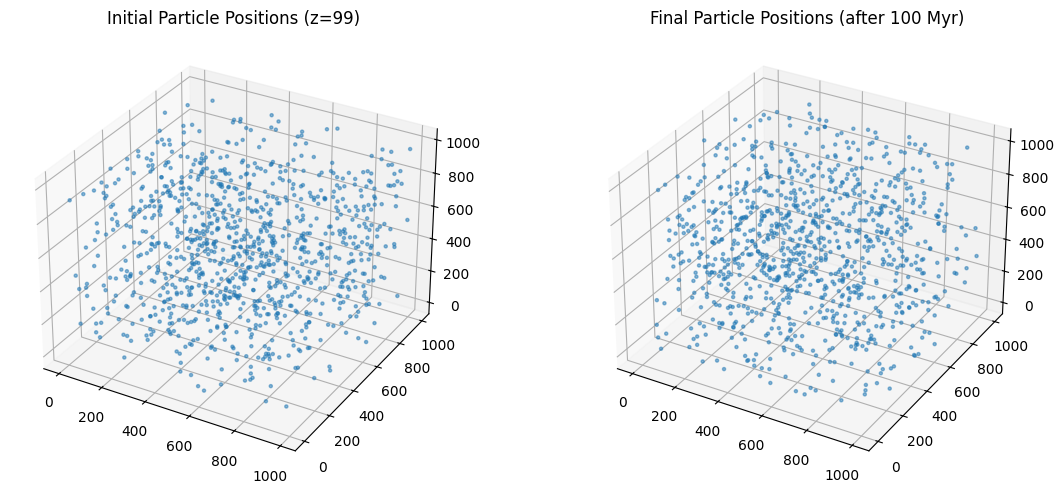

In [ ]:
# Visualizations:
subset = np.random.choice(len(positions), 1000, replace=False)
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(positions_history[0][subset, 0], positions_history[0][subset, 1],
           positions_history[0][subset, 2], s=5, alpha=0.5)
ax1.set_title("Initial Particle Positions (z=99)")
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(positions_history[-1][subset, 0], positions_history[-1][subset, 1],
           positions_history[-1][subset, 2], s=5, alpha=0.5)
ax2.set_title("Final Particle Positions (after 100 Myr)")
plt.tight_layout()
plt.show()

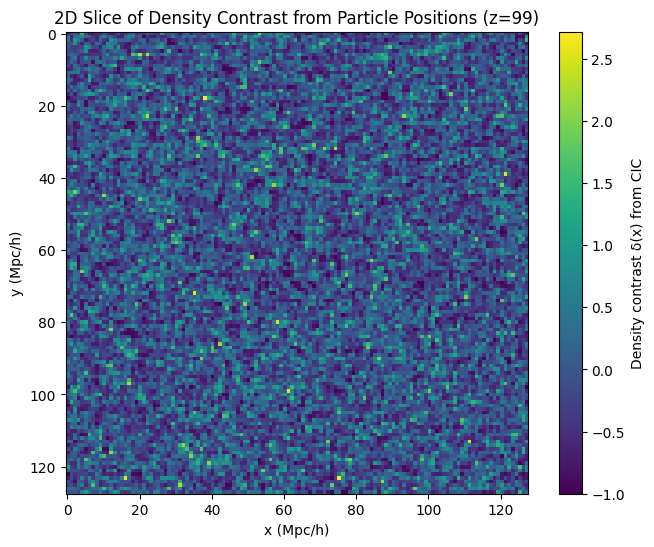

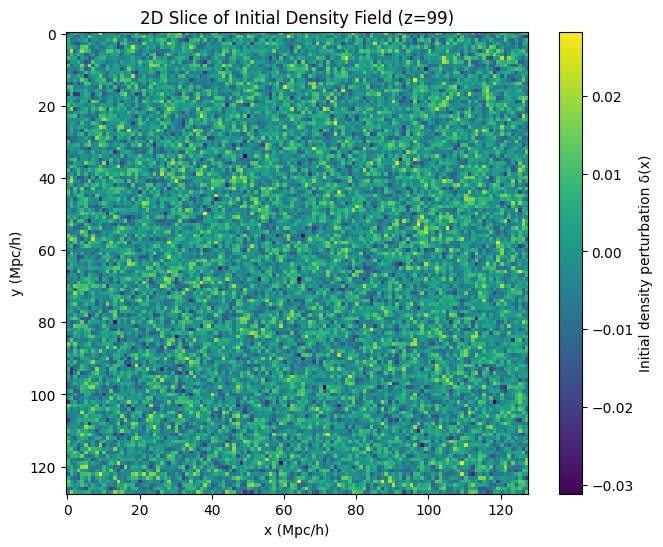

Standard deviation of initial δ: 8.000e-03
Standard deviation of CIC δ: 5.442e-01


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming the following variables are defined from your simulation:
# - positions_history: list of particle positions at each timestep, with positions_history[-1] being the final positions
# - N: grid size (e.g., 128 for a 128^3 grid)
# - L: physical box size in Mpc/h
# - a_current: final scale factor after the leapfrog integration
# - cic_interpolation: function that computes the density grid from particle positions

# Step 1: Get the final particle positions
final_positions = positions_history[-1]

# Step 2: Compute the density grid using CIC interpolation
density_final = cic_interpolation(final_positions, N, L)

# Step 3: Calculate the mean density
# Total mass is distributed over N^3 grid cells; mean density is total mass / number of cells
mean_density_final = np.sum(density_final) / (N**3)

# Step 4: Compute the density contrast δ(x) = (ρ(x) / ρ_mean) - 1
delta_final = (density_final / mean_density_final) - 1

# Plot a 2D slice of the CIC density contrast
plt.figure(figsize=(8, 6))
plt.imshow(delta_final[N//2, :, :], cmap='viridis')
plt.colorbar(label='Density contrast δ(x) from CIC')
plt.title('2D Slice of Density Contrast from Particle Positions (z=99)')
plt.xlabel('x (Mpc/h)')
plt.ylabel('y (Mpc/h)')
plt.show()
plt.show()

# Plot the initial density field for comparison
plt.figure(figsize=(8, 6))
plt.imshow(density_field[N//2, :, :], cmap='viridis')
plt.colorbar(label='Initial density perturbation δ(x)')
plt.title('2D Slice of Initial Density Field (z=99)')
plt.xlabel('x (Mpc/h)')
plt.ylabel('y (Mpc/h)')
plt.show()

# Compare statistics
print(f"Standard deviation of initial δ: {np.std(density_field):.3e}")
print(f"Standard deviation of CIC δ: {np.std(delta_final):.3e}")